## University of Bari Aldo Moro
Master Degree in <b>Computer Science</b> - <b>Computer Vision Course</b><br>

### Vision Transformer for Unmanned Aerial Vehicles Agronomic Research
- [Dependencies](#dependencies)
- [Libraries](#libraries)
- [Dataset](#dataset)
    - [Parameters](#parameters)
    - [GCP Finder](#gcp_finder)
    - [Plots Clipper](#plots_clipper)
    - [Ground Truth](#ground-truth)
    - [Creation](#creation)
    - [Loading](#loading)
    - [Splitting](#splitting)
- [Dataloader](#dataloader)
- [Model](#model)
    - [Training](#training)
    - [Evaluation](#evaluation)
    - [Save](#save)
    - [Prediction](#prediction)
- [Visualization](#visualization)

### Dependencies
<a name='dependencies'></a>

In [1]:
# %pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [2]:
# Libraries

from argparse import ArgumentParser
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.optim import Adam, AdamW
from torchmetrics import LogCoshError
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.models import get_model, ViT_B_32_Weights, ViT_B_16_Weights, ViT_L_16_Weights
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import mlflow.pytorch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch

d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
d:\Repository\UAV_ViT\venv\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [3]:
# Import from notebooks

import import_ipynb

from notebooks.gcp_finder import GCPFinder
from notebooks.clipper import Clipper
from notebooks.dataset import BaseDataset, PlotsDataset
from notebooks.utils import show_dataset_samples, get_means_stds, find_lr, find_steepest_point
from notebooks.vit import UAV_vit

importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\gcp_finder.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\clipper.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\dataset.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\utils.ipynb
importing Jupyter notebook from d:\Repository\UAV_ViT\notebooks\vit.ipynb


#### Paths
<a name="paths"></a>

In [4]:
# Paths

DATASET_PATH = "./data/dataset"
PLOT_PATH = "./data/plots"
SAMPLES_PATH = "./data/raw_samples"
SHAPEFILE_PATH = "./data/shapefile/all_plots.shp"
ORTHOMOSAIC_PATH = "./data/orthophoto/raster.tif"
VISUALS_PATH = "./data/visuals/"
GCP_PATH = "./data/GCP_Images"
GROUND_TRUTH_CSV_PATH = './data/ground_truth/ground_truth.csv'
GROUND_TRUTH_XLSX_PATH = './data/ground_truth/ground_truth.xlsx'
MODEL_PATH = "./data/models/"
CHECKPOINT_PATH = "./data/checkpoints/"

In [5]:
# Cuda setup

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used", device)
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead", device)

GPU is available and being used cuda


## Preprocessing
<a name='preprocessing'></a>

#### Ground truth
<a name="ground_truth"></a>

In [6]:
# Loading the ground truth
# ground_truth = pd.read_csv(GROUND_TRUTH_CSV_PATH)
ground_truth = pd.read_excel(GROUND_TRUTH_XLSX_PATH)

# Elevation format conversion to float32
ground_truth["elev"] = ground_truth["elev"].astype("float32")
labels_norm = ground_truth["elev"]
ground_truth.head()

,test,DataFile 3,elev,elev-max,lunghezza,file,plot
0,2A2B,2A2B_1.las,2.1590,2.80,6,2A2B_1,2A2B_1.png
1,2A2B,2A2B_2.las,2.1590,2.86,6,2A2B_2,2A2B_2.png
2,2A2B,2A2B_3.las,2.1336,2.69,6,2A2B_3,2A2B_3.png
3,2A2B,2A2B_4.las,2.3622,2.64,6,2A2B_4,2A2B_4.png
4,2A2B,2A2B_5.las,2.0574,2.65,6,2A2B_5,2A2B_5.png


In [7]:
# Targets normalization

scaler = MinMaxScaler()
ground_truth["elev"] = scaler.fit_transform(ground_truth[["elev"]])

In [8]:
# Scaled ground truth head

ground_truth.head()

,test,DataFile 3,elev,elev-max,lunghezza,file,plot
0,2A2B,2A2B_1.las,0.538461,2.80,6,2A2B_1,2A2B_1.png
1,2A2B,2A2B_2.las,0.538461,2.86,6,2A2B_2,2A2B_2.png
2,2A2B,2A2B_3.las,0.512820,2.69,6,2A2B_3,2A2B_3.png
3,2A2B,2A2B_4.las,0.743590,2.64,6,2A2B_4,2A2B_4.png
4,2A2B,2A2B_5.las,0.435898,2.65,6,2A2B_5,2A2B_5.png


#### Ground Control Point (GCP) Finder

<a name='gcp_finder'></a>

In [9]:
# gcp_finder = GCPFinder(DATASET_PATH, GCP_PATH)
# gcp_finder.gcp_mover()

#### Plots Clipper
<a name='plots_clipper'></a>

In [10]:
# clipper = Clipper(ORTHOMOSAIC_PATH, SHAPEFILE_PATH, PLOT_PATH)
# clipper.start()

## Dataset
<a name="dataset"></a>

### Parameters
<a name='parameters'></a>

In [11]:
# Hyperparameters

TEST_SIZE = 0.2 # % of dataset
VAL_SIZE = 0.2  # % of training set

MAX_EPOCS = -1
BATCH_SIZE = 16
WORKERS = 8
IMG_SIZE = (224,224)

BACKBONE_NAME = "vit_l_16"
# BACKBONE_WEIGHTS = None
# BACKBONE_WEIGHTS = ViT_L_16_Weights.DEFAULT
BACKBONE_WEIGHTS = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
ES_PATIENCE = 10
ES_STOPPING_THRESHOLD = 1e-4
ES_DIVERGENCE_THRESHOLD = 5

USE_LR_FINDER = False
learning_rate = 1e-4
FROZEN_LAYERS = 6
WEIGHT_DECAY = 1e-1
DROPOUT = 0.2
ATTENTION_DROPOUT = 0.2

#### Augmentation

In [12]:
# Transformations

hue = 0.1
saturation = 0.1
brightness = 0.1
contrast = 0.1

uav_vit_transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomApply([v2.RandomErasing(p=0.2, scale=(0.01, 0.1), ratio=(0.3, 3.3))], p=0.3), # Randomly add shadow patterns
    # v2.RandomApply([v2.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.2)], p=0.1), # Randomly change brightness, contrast, saturation and hue
])

In [13]:
# Datasets definition

base_dataset = {
    "name": "base",
    "dataset": PlotsDataset(labels=ground_truth, img_dir=PLOT_PATH, img_size=IMG_SIZE, transforms=None),
}
augmented_dataset = {
    "name": "augmented",
    "dataset": PlotsDataset(labels=ground_truth, img_dir=PLOT_PATH, img_size=IMG_SIZE, transforms=uav_vit_transforms),
}

concat_dataset = {
    "name": "concat",
    "dataset": ConcatDataset([base_dataset["dataset"], augmented_dataset["dataset"]])
}

dataset = base_dataset["dataset"]

print(f"Dataset length: {len(dataset)}")
print(f"Image type: {type(dataset[0][0])}")
print(f"Image shape: {dataset[0][0].shape})")
print(f"Label type: {type(dataset[0][1])}")

Dataset length: 705
Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224]))
Label type: <class 'numpy.float32'>


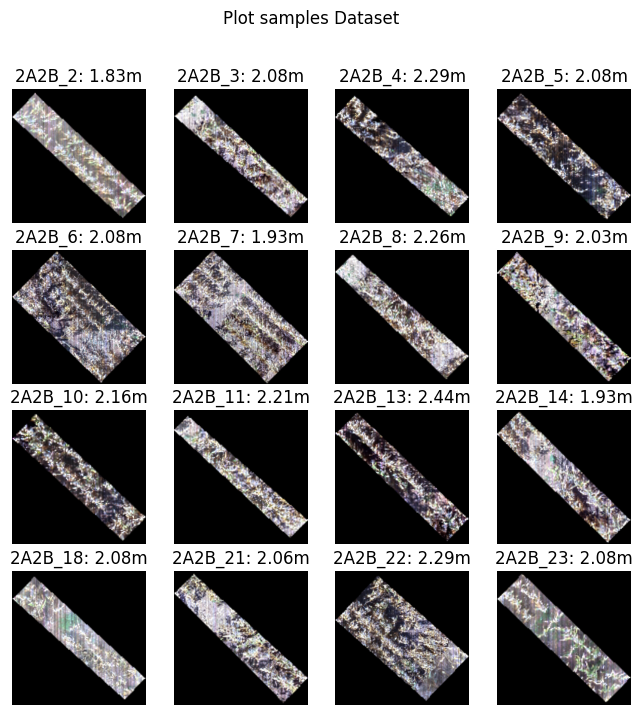

In [14]:
# Dataset samples

show_dataset_samples(dataset, labels_norm, "Dataset")

Text(0.5, 1.0, 'Distribution of pixels')

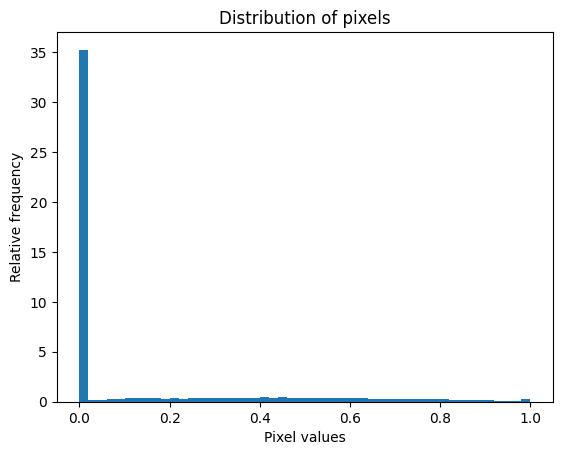

In [15]:
# Pixel distribution

plt.hist(dataset[0][0].permute(1,2,0).ravel(), bins=50, density=True)
plt.xlabel("Pixel values")
plt.ylabel("Relative frequency")
plt.title("Distribution of pixels")

In [16]:
# Datasets means and stds

means, stds = get_means_stds(dataset)
print(f'Dataset means: {means}\nstds: {stds}')

Dataset means: [0.16330452263355255, 0.15598873794078827, 0.1589348316192627]
stds: [0.2748134136199951, 0.2666980028152466, 0.26911261677742004]


In [17]:
# Dataset split

train_set, test_set = train_test_split(dataset, test_size=TEST_SIZE)
train_set, val_set = train_test_split(train_set, test_size=VAL_SIZE)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 451
Validation set size: 113
Test set size: 141


In [18]:
# Labels split

labels_train, labels_test = train_test_split(labels_norm, test_size=TEST_SIZE)
labels_train, labels_val = train_test_split(labels_train, test_size=VAL_SIZE)

print(f"Training set size: {len(labels_train)}")
print(f"Validation set size: {len(labels_val)}")
print(f"Test set size: {len(labels_test)}")

Training set size: 451
Validation set size: 113
Test set size: 141


In [19]:
# Dataloaders

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=WORKERS)

print(f"Train Dataloader size: {len(train_loader)}")
print(f"Validation Dataloader size: {len(val_loader)}")
print(f"Test Dataloader size: {len(test_loader)}")

Train Dataloader size: 29
Validation Dataloader size: 8
Test Dataloader size: 9


#### Model
<a name='model'></a>

In [20]:
# Backbone

backbone = get_model(BACKBONE_NAME, weights=BACKBONE_WEIGHTS)
backbone.heads

Sequential(
  (head): Linear(in_features=1024, out_features=1000, bias=True)
)

In [21]:
# Vargs setup

def setup_vargs():
    parser = ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=BATCH_SIZE)
    parser.add_argument('--no_grad_layers_n', type=int, default=FROZEN_LAYERS)
    parser.add_argument('--dropout', type=float, default=DROPOUT)
    parser.add_argument('--attention_dropout', type=float, default=ATTENTION_DROPOUT)

    args, _ = parser.parse_known_args()

    vargs = vars(args)
    return vargs

In [22]:
# Criterion, preliminary optimizer, vargs

criterion = LogCoshError()
optimizer = AdamW(backbone.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
vargs = setup_vargs()

#### LR Optimizer

In [ ]:
# Yet another try to find the best learning rate
import pytorch_lightning as pl
def find_lr(
    model: pl.LightningModule,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    min_lr: float = 1e-7,
    max_lr: float = 1e4,
    num_iters: int = 100,
    div_factor: float = 10,
    patience: int = 5,
    verbose: bool = True,
):
    """
    Trova il learning rate ottimale per un modello PyTorch Lightning.

    Args:
        model: Il modello da ottimizzare.
        dataloader: Il dataloader utilizzato per l'ottimizzazione.
        optimizer: L'ottimizzatore da utilizzare.
        min_lr: Il learning rate minimo da provare.
        max_lr: Il learning rate massimo da provare.
        num_iters: Il numero di iterazioni da eseguire per ogni learning rate.
        div_factor: Il fattore di divisione da utilizzare per ridurre il learning rate.
        patience: Il numero di iterazioni senza miglioramento prima di ridurre il learning rate.
        verbose: Se `True`, stampa i progressi dell'ottimizzazione.

    Returns:
        Il learning rate ottimale.
    """

    # Inizializza il learning rate.
    lr = min_lr

    # Loop sui vari learning rate.
    for i in range(num_iters):
        # Imposta il learning rate.
        optimizer.param_groups[0]["lr"] = lr

        # Esegue un'iterazione di allenamento.
        model.train()
        loss = None
        loss_best = None
        for batch in dataloader:
            loss = model(batch["input"])
            loss.backward()
            optimizer.step()

        assert loss is not None
        assert loss_best is not None
        # Controlla se il loss è migliorato.
        loss_current = loss.item()
        loss_best = min(loss_current, loss_best)
        if loss_current > loss_best * 1.25:
            # Il loss è peggiorato, quindi riduci il learning rate.
            lr = lr / div_factor
            i = 0

        # Stampa i progressi.
        if verbose:
            print(f"Learning rate: {lr}")
            print(f"Loss: {loss_current}")

    # Ritorna il learning rate ottimale.
    return lr

# Learning rate finder
base_model = UAV_vit(backbone, criterion, optimizer, **vargs)
lr = find_lr(base_model, train_loader, optimizer)


In [26]:
# LR finder

# if(USE_LR_FINDER):
    
#     base_model = UAV_vit(backbone, criterion, optimizer, **vargs)
#     base_model.backbone.heads

#     # Backbone backup
#     torch.save(backbone.state_dict(), MODEL_PATH + "backbone.pth")

#     # LR finder

#     log_lrs, test_loss = find_lr(backbone, criterion, optimizer, train_loader)
#     print("log_lrs: ", log_lrs)
#     print("losses: ", test_loss)
#     plt.plot(log_lrs, test_loss)
#     plt.show()
#     plt.savefig(VISUALS_PATH + "lr_finder.png")

#     # Find steepest point and slope

#     max_slope_log_lr = find_steepest_point(log_lrs, test_loss)
    
#     # Update optimizer's args
#     learning_rate = 10 ** max_slope_log_lr
    
#     print(f"Suggested learning rate: {learning_rate}")

#     # Backbone rollback after LR finder

#     backbone.load_state_dict(torch.load(MODEL_PATH + "backbone.pth"))

#     # Optimizer's update

#     optimizer = AdamW(backbone.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)

In [27]:
# MLFlow init

mlflow.pytorch.autolog()
mlflow.start_run()

<ActiveRun: >

In [28]:
# Model

model = UAV_vit(backbone, criterion, optimizer, **vargs)

## Training
<a name='training'></a>

In [29]:
# Callbacks

checkpoint_cb = ModelCheckpoint(dirpath=CHECKPOINT_PATH, save_top_k=1, monitor="val_loss", mode="min", filename="uav_vit-{epoch:02d}-{val_loss:.3f}")
earlyStopping_cb = EarlyStopping(monitor="val_loss", patience=ES_PATIENCE, stopping_threshold=ES_STOPPING_THRESHOLD, divergence_threshold=ES_DIVERGENCE_THRESHOLD, mode="min")

In [30]:
# Trainer

trainer = pl.Trainer(
    log_every_n_steps=1,
    max_epochs=MAX_EPOCS,
    callbacks=[earlyStopping_cb, checkpoint_cb],
    num_sanity_val_steps=0,
    enable_checkpointing=True,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [31]:
# Fit

trainer.fit(model, train_loader, val_loader)

d:\Repository\UAV_ViT\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\Repository\UAV_ViT\data\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params
---------------------------------------------------
0 | backbone     | VisionTransformer | 303 M 
1 | criterion    | LogCoshError      | 0     
2 | val_metrics  | MetricCollection  | 0     
3 | test_metrics | MetricCollection  | 0     
---------------------------------------------------
298 M     Trainable params
4.4 M     Non-trainable params
303 M     Total params
1,213.211 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([3, 1])


Validation: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([1, 1])


2023/10/28 13:05:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.0+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/28 13:06:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Thuls\AppData\Local\Temp\tmpsucilxrx\model\data, flavor: pytorch), fall back to return ['torch==2.0.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/28 13:06:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Repository\UAV_ViT\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


## Testing
<a name='testing'></a>

In [32]:
# Best model path

checkpoint_cb.best_model_path

'D:\\Repository\\UAV_ViT\\data\\checkpoints\\uav_vit-epoch=01-val_loss=0.015.ckpt'

In [33]:
# Load best model

model = UAV_vit.load_from_checkpoint(checkpoint_cb.best_model_path, backbone=backbone, criterion=criterion, optimizer=optimizer, labels=labels_norm, **vargs)

In [34]:
# Test best model

trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([13, 1])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_ExplainedVariance   │   -0.000718028808478266   │
│  test_MeanAbsoluteError   │    0.14359363913536072    │
│   test_MeanSquaredError   │   0.030726581811904907    │
│         test_loss         │   0.015156302601099014    │
└───────────────────────────┴───────────────────────────┘

[{'test_MeanSquaredError': 0.030726581811904907,
  'test_MeanAbsoluteError': 0.14359363913536072,
  'test_ExplainedVariance': -0.000718028808478266,
  'test_loss': 0.015156302601099014}]

In [35]:
# Extract test results

outputs = model.test_output
test_loss = model.test_loss
test_label_mean = model.test_label_mean
labels_test_norm = [x[1] for x in test_set]
# residuals = labels_test_norm - outputs
residuals = []
for lab, out in zip(labels_test_norm, outputs):
    residuals.append(lab - out)

In [36]:
# R2 score

r2 = r2_score(labels_test_norm, outputs)
print(f"R2 score: {r2}")

R2 score: -0.12914428392272237


#### Inference

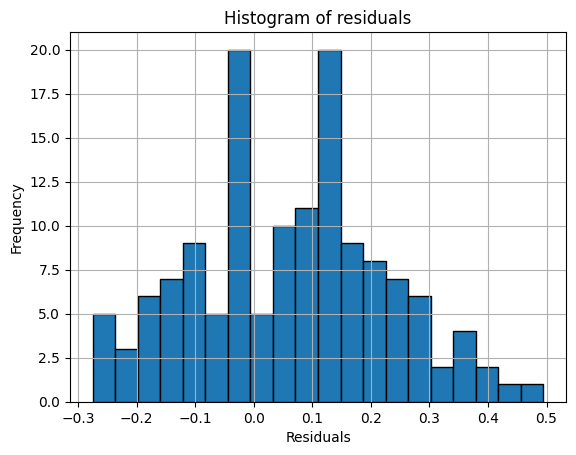

In [37]:
# Residuals' histogram plot

plt.hist(residuals, bins=20, edgecolor='k')  # Il parametro 'bins' determina il numero di barre nell'istogramma.
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

Text(0, 0.5, 'Residual Error')

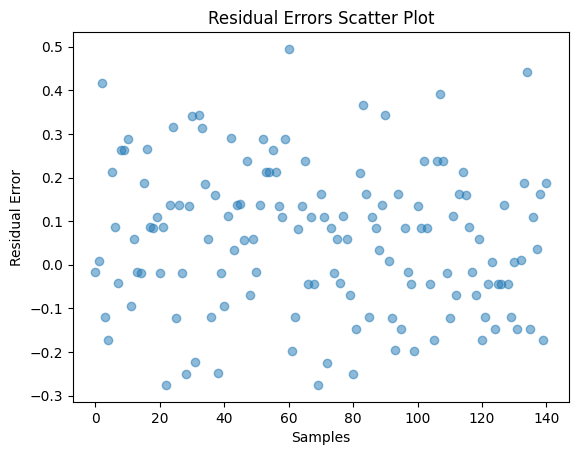

In [38]:
# Residuals errors scatter plot

plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.title('Residual Errors Scatter Plot')
plt.xlabel('Samples')
plt.ylabel('Residual Error')

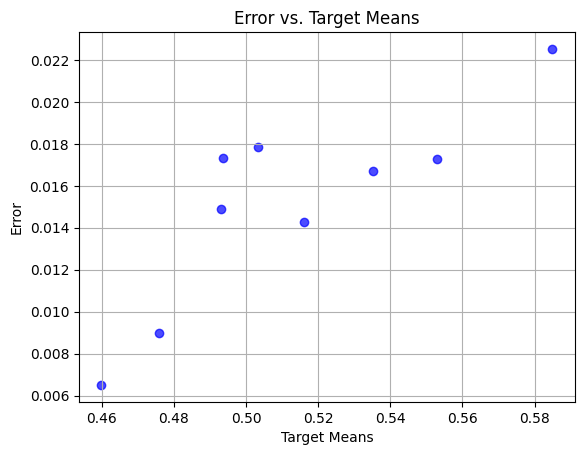

In [39]:
# Losses vs targets means scatter plot

plt.scatter(test_label_mean, test_loss, color='blue', alpha=0.7)
plt.title('Error vs. Target Means')
plt.xlabel('Target Means')
plt.ylabel('Error')
plt.grid(True)

plt.show()

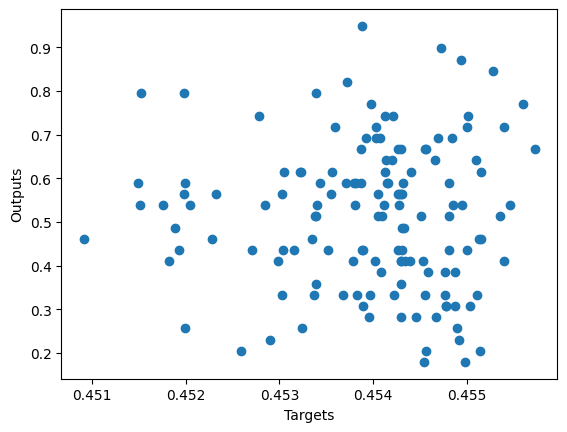

In [40]:
# Predicted vs targets scatter plot

plt.ylabel('Outputs')
plt.xlabel('Targets')
plt.scatter(outputs, labels_test_norm)

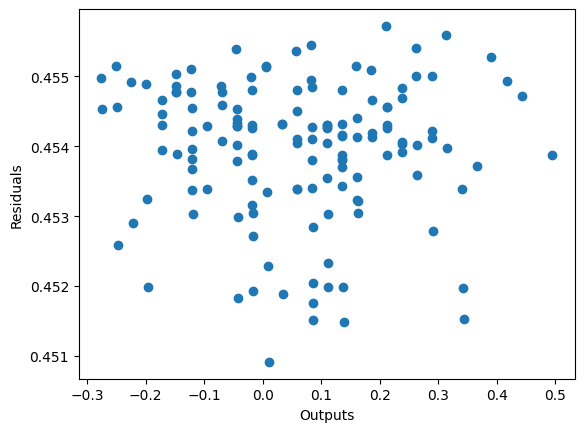

In [41]:
# Residuals vs outputs scatter plot

plt.ylabel('Residuals')
plt.xlabel('Outputs')
plt.scatter(residuals, outputs)

In [42]:
# Log parameters

mlflow.log_param("R2Score", r2)
mlflow.log_params({"model": BACKBONE_NAME, "weights": BACKBONE_WEIGHTS, "lr_finder": USE_LR_FINDER})
mlflow.log_params({"batch_size": BATCH_SIZE, "train_epochs": MAX_EPOCS})
mlflow.log_params({"dropout": DROPOUT, "dropout_attention": ATTENTION_DROPOUT, "frozen layers": FROZEN_LAYERS})
mlflow.log_artifact("main.ipynb")
mlflow.log_artifact("notebooks/vit.ipynb")
mlflow.log_artifact("notebooks/dataset.ipynb")
mlflow.end_run()

In [43]:
samplesDataset = BaseDataset(SAMPLES_PATH, IMG_SIZE)
samplesDataloader = DataLoader(samplesDataset, batch_size=BATCH_SIZE)

In [44]:
predictions = trainer.predict(model, dataloaders=samplesDataloader, return_predictions=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Repository\UAV_ViT\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [45]:
predictions = np.concatenate(predictions)

In [46]:
# Unscaled predictions

predictions = np.array(predictions).reshape(1, -1)
unscaled = scaler.inverse_transform(predictions)

print(f"Predicted result {predictions}\nUnscaled result {unscaled}")

Predicted result [[0.45004061 0.45036939 0.44974291 0.4502134  0.4496915  0.44987124
  0.44981033 0.45096821 0.45194823 0.45110524 0.45179167 0.45198032
  0.45149362 0.45099154 0.45163065 0.45148849 0.4517819  0.45177802
  0.4516218  0.45252714 0.45096686]]
Unscaled result [[2.07141017 2.07173586 2.07111527 2.07158134 2.07106435 2.0712424
  2.07118205 2.07232905 2.07329986 2.07246479 2.07314478 2.07333165
  2.07284952 2.07235216 2.07298527 2.07284445 2.07313509 2.07313125
  2.0729765  2.07387332 2.07232772]]
